In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
import seaborn as sns

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [5]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [6]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [7]:
df

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008


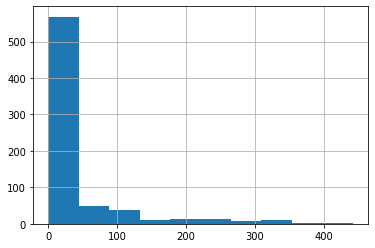

In [8]:
df['MIC'].hist()

In [9]:
df['pIC50'] = df['MIC'].apply(lambda x: -np.log(x*1e-6))

In [10]:
df

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,18.297579
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008,23.248994


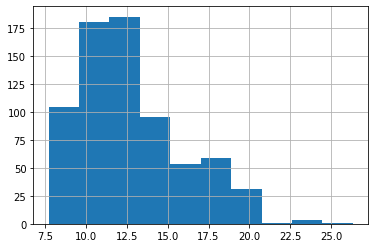

In [11]:
df['pIC50'].hist()

In [12]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [13]:
aa_freq = reduce_by_kmer_frequency(df)

In [14]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1189.90sequence/s]


In [15]:
physicochemical_prop = get_physicochemical_properties(df)

In [16]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [17]:
y = df[['pIC50', 'MIC']]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [20]:
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

In [21]:
def multi_objective_score(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    std_diff = abs(np.std(y_pred) - np.std(y_true))
    return mape + 10*std_diff
multi_objective_scorer = make_scorer(multi_objective_score, greater_is_better=False)

In [25]:
from geneal.genetic_algorithms import ContinuousGenAlgSolver

In [42]:
def fitness_function(chromosome):
    svr = SVR(C=100, gamma=3)
    cv_score = cross_val_score(svr, X_train, y_train_pmic, cv=5, fit_params={"sample_weight":chromosome},
                               scoring=mape_scorer)
    return cv_score.mean()

In [43]:
solver = ContinuousGenAlgSolver(
    n_genes=X_train.shape[0], 
    fitness_function=fitness_function,
    pop_size=50,
    max_gen=200,
    mutation_rate=0.2,
    selection_rate=0.6,
    selection_strategy="roulette_wheel"
)

Iteration: 20
Best fitness: -14.869760933033849
Iteration: 40
Best fitness: -14.376521623947415
Iteration: 60
Best fitness: -14.158122914611862
Iteration: 80
Best fitness: -14.158122914611862
Iteration: 100
Best fitness: -14.158122914611862
Iteration: 120
Best fitness: -14.062990986682113
Iteration: 140
Best fitness: -13.992828550738531
Iteration: 160
Best fitness: -13.924132855973687
Iteration: 180
Best fitness: -13.924132855973687
Iteration: 200
Best fitness: -13.507513593885992


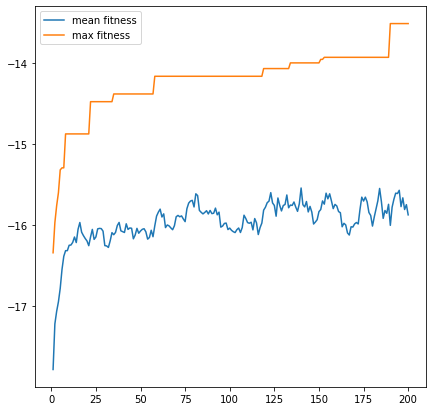


#############################
#			STATS			#
#############################


Total running time: 15 minutes, 55 seconds


Population size: 50
Number variables: 569
Selection rate: 0.6
Mutation rate: 0.2
Number Generations: 200

Best fitness: -13.507513593885992
Best individual: [ 5.17192247e+00  5.40130051e+00  5.07364754e+00  4.89402011e+00
  9.51476637e+00  4.19366464e+00 -9.93105806e+00 -9.70763058e+00
  4.10261520e-01  8.80638023e-01  4.74613524e+00  7.62848937e+00
  1.29031455e+00 -1.34421205e+00  7.55880180e+00 -3.15424721e+00
  2.25258955e+00 -4.75072729e+00  9.45028982e+00 -2.71305759e+00
  2.34777865e+00  7.46875088e+00 -4.16574898e+00 -1.70178147e+00
  6.88571706e+00  2.80036959e+00  6.85916680e+00  3.63270125e-01
 -5.37180997e+00  4.43070736e+00 -1.06063692e+00 -6.45001675e+00
  8.12992296e+00  3.07484165e+00 -7.41491365e+00  4.46905544e+00
 -9.75422047e+00  3.36484107e+00 -7.52144299e+00 -1.58724330e+00
  3.32727866e+00 -7.52541097e+00  8.11295597e+00  1.90919631e+00
  4.62

In [44]:
solver.solve()

In [40]:
svr = SVR(C=100, gamma=3)
cv_score = cross_val_score(svr, X_train, y_train_pmic, cv=5,
                               scoring=mape_scorer)

In [41]:
cv_score.mean()

-14.995841393329982

In [55]:
keep_point = np.where(solver.best_individual_ > 0)[0]

In [59]:
df2 = df.iloc[keep_point,:]

In [60]:
aa_freq = reduce_by_kmer_frequency(df2)

In [61]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df2['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

loading Word2Vec object from ../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None
loading wv recursively from ../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None.wv.* with mmap=None
setting ignored attribute vectors_norm to None
loading vocabulary recursively from ../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None.vocabulary.* with mmap=None
loading trainables recursively from ../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None.trainables.* with mmap=None
setting ignored attribute cum_table to None
loaded ../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None


/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 312/312 [00:00<00:00, 1011.85sequence/s]


In [62]:
physicochemical_prop = get_physicochemical_properties(df2)

In [63]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [64]:
y = df2[['pIC50', 'MIC']]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [69]:
svr = SVR(C=100, gamma=5)
cv_score = cross_val_score(svr, X_train, y_train_pmic, cv=5, scoring=mape_scorer)
cv_mean = cv_score.mean()
print(cv_score, cv_mean)

_ = svr.fit(X_train, y_train_pmic)
y_pred = svr.predict(X_test)

print(np.std(y_test_pmic), np.std(y_pred))

[-13.02308362 -10.64224148 -12.48650891 -12.71021793 -11.37619722] -12.047649829322996
1.9903369196384313 1.6004568089335711


In [70]:
ape = 100*np.abs(y_test_pmic-y_pred)/y_test_pmic

In [71]:
y_pred_mic = np.exp(-y_pred)/1e-6

In [72]:
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [73]:
gg = list(zip(y_test_pmic.round(4), y_pred.round(4), ape, y_test_mic.round(4), y_pred_mic.round(4), ape_mic))

In [74]:
sorted(gg, key=lambda x:x[5])

[(7.8913, 7.8734, 0.22583848899136155, 374.0, 380.725, 1.7981240861133378),
 (9.2103, 9.2523, 0.45542691364956833, 100.0, 95.8921, 4.107879280041729),
 (10.1019, 10.1721, 0.6945954662037052, 41.0, 38.2217, 6.776244250461426),
 (10.4833, 10.3732, 1.0498595481309316, 28.0, 31.2577, 11.63450374336094),
 (11.8006, 11.6602, 1.189638523901477, 7.5, 8.6304, 15.071624854221332),
 (11.8456, 11.685, 1.356114470338013, 7.17, 8.4195, 17.426211394073423),
 (14.8316, 14.6044, 1.532322470014401, 0.362, 0.4544, 25.516654734811787),
 (10.2545, 9.9291, 3.1729609849758234, 35.2, 48.7359, 38.45430494711982),
 (12.2061, 12.7028, 4.069481253228161, 5.0, 3.0426, 39.14789890515285),
 (9.2103, 9.8644, 7.101209472147627, 100.0, 51.9938, 48.00619259750502),
 (12.8562, 13.5135, 5.112759342471097, 2.61, 1.3526, 48.17536334524459),
 (12.7169, 13.3915, 5.304386010009347, 3.0, 1.5282, 49.06161254471147),
 (12.6006, 12.1985, 3.191410078697448, 3.37, 5.0382, 49.50157600093518),
 (9.9035, 10.6128, 7.1618734099677, 50.0,

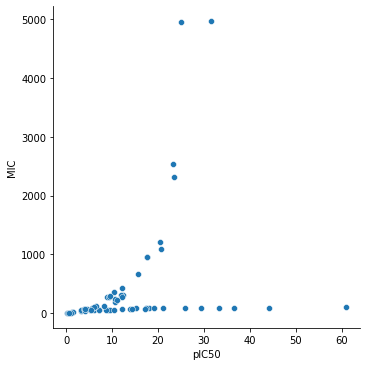

In [76]:
sns.relplot(x=ape, y=ape_mic)